

###**Relatório Experimental da Aplicação dos Algoritmos: k-vizinho mais próximo (kNN) e quantização de vetores de aprendizagem (LVQ)**

Disciplina: Aprendizagem de Máquina - IN1102

Docente: Prof. Dr. Leandro Maciel Almeida

Discentes: 
Lucas Benevides V. de Amorim, Cynthia Moreira Maia e Sara Bandeira

Coutinho.


##**Introdução**

Este relatório tem como objetivo apresentar uma análise experimental da aplicação de dois algoritmos de aprendizagem supervisionada: k-vizinhos mais próximos (kNN) e quantização de vetores de aprendizagem (LVQ). No kNN para classificar uma instância desconhecida como pertencente a uma determinada classe, são considerados seus $k$ vizinhos mais próximos (onde $k$ é um hiperparâmetro do algoritmo) de acordo com alguma métrica de distância, sendo a mais usual a distância euclidiana. A instância é classificada como pertencente à classe mais votada, ou seja, majoritária entre os $k$ vizinhos mais próximos [1]. 
 
No LVQ para o problema de classificação, são utilizados um ou mais protótipos que representam as classes do conjunto de dados [2]. Tem-se os vetores de entrada e os vetores unitários de saída, que representam as classes. Ao verificar um vetor de entrada, se esse vetor não corresponde ao protótipo analisado, considera-se o protótipo mais próximo por meio de uma métrica de distância e esse protótipo é afastado do vetor, caso contrário, esse protótipo é deslocado em direção ao vetor analisado. Diferente do kNN, que tem como hiperparâmetro o valor de $k$, no LVQ tem-se a taxa de desempenho ($\alpha$)[3]. 
 
Para os experimentos foi utilizada a base de dados, Abalone, oriunda do repositório de dados da UCI, que é um problema de classificação que envolve 28 classes e tem 4177 instâncias. O objetivo é prever a idade do Abalone, um molusco marinho, a partir de medições físicas como diâmetro e massa de diversas partes do organismo. O atributo alvo, o número de anéis da concha, pode ser utilizado como um valor contínuo ou como um problema de classificação, é utilizado como marcador de idade, que pode ser obtida somando-se 1,5.










## **Experimento**

Os algoritmos foram implementados na ferramenta Colab, com uso da linguagem Python. O pacote principal utilizado foi o sklearn.  


### Carregamento de bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from collections import Counter
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

###Carregamento dos dados

In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', names = ['Sex', 'Lenght', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings'])
data

,Sex,Lenght,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


### Pré-processamento:



Técnicas de pré-processamento são importantes para melhorar a qualidade dos dados e torná-los mais adequados para o consumo dos algoritmos de aprendizado de máquina [1]. Dessa forma, foram verificados alguns pontos na base de dados, como: valores faltantes (não contém), atributos categóricos (um atributo: Sex) que foi tratado por meio da técnica de one-hot-encoding, para que fosse transformado em atributos numéricos. No caso, havia na base 3 valores para este atributo: M, F, I. Dessa forma foram gerados dois novos atributos binários Sex_M e Sex_F, não sendo necessário um atributo para Sex_I já que é consequência de valor Falso para os demais.

Observou-se que as classes estavam altamente desbalanceadas, com número de objetos variando de 1 para as classes minoritárias para 689 em uma das classes. A presença de dados desbalanceados pode prejudicar a capacidade de capturar a tendência dos dados e gerar um modelo suficientemente genérico. Para tratar este problema, fez-se uso da metodologia Oversampling, com a técnica SMOTE (Synthetic Minority Over-sampling Technique), essa técnica gera novas amostras para as classes minoritárias.

####Análise dos Dados

In [ ]:
#verificar número de dados ausentes. No caso, não apresenta.
data.isnull().sum()

Sex               0
Lenght            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [ ]:
#correlação dos atributos com o atributo-alvo.
corr_matrix = data.corr()
corr_matrix['Rings'].sort_values(ascending=False)

Rings             1.000000
Shell weight      0.627574
Diameter          0.574660
Height            0.557467
Lenght            0.556720
Whole weight      0.540390
Viscera weight    0.503819
Shucked weight    0.420884
Name: Rings, dtype: float64

(array([  1.,   1.,  15.,  57., 115., 259., 391., 568., 689., 634., 487.,
        267., 203., 126., 103.,  67.,  58.,  42.,  32.,  26.,  14.,   6.,
          9.,   2.,   1.,   1.,   2.,   1.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29.]),
 <a list of 28 Patch objects>)

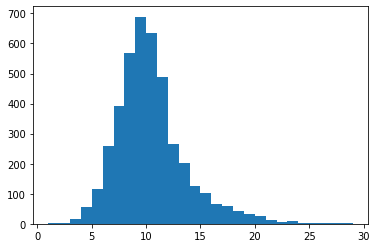

In [ ]:
#Distribuição de frequência da variável alvo.
n_bins = len(data['Rings'].unique())
plt.hist(data['Rings'], bins=n_bins)

#### Codificação dos atributos categóricos com - One-hot encoding:

In [ ]:
data['Sex'] = data['Sex'].astype(pd.api.types.CategoricalDtype(['M', 'F', 'I']))
att_encoded = pd.get_dummies(data['Sex'], prefix = 'Sex')
data = data.drop(['Sex'], axis = 1)
data = pd.concat([att_encoded, data], axis = 1)
#data

In [ ]:
# Removendo a coluna 'Sex_I' já que é correlacionada a Sex_M e Sex_F (Sex_I = not (Sex_M and Sex_F))
data.drop('Sex_I', inplace=True, axis=1)
data

,Sex_M,Sex_F,Lenght,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,1,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,0,1,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,1,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,0,0,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...,...
4172,0,1,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,1,0,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,1,0,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,0,1,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


#### Separação das variáveis preditoras (X) da variável alvo (y):

In [ ]:
X = data[data.columns[:-1]] # Todas as colunas exceto a última
y = data[data.columns[[-1]]] # A última coluna

#### Balanceamento das classes

Uma metodologia que se mostra eficiente, em várias aplicações, para balanceamento interclasses é  o oversampling, criando instâncias sintéticas das classes minoritárias com a técnica SMOTE. Entretanto, esta técnica precisa que cada classe tenha ao menos k instâncias, já que utiliza essas k instâncias para gerar uma instância sintética naquela vizinhança. Portanto, considerando um k=6 iremos remover as instâncias das classes com menos de 6 representantes.

In [ ]:
# Verificando novamente as frequências das classes:
counts = dict(Counter(y.values.ravel()))
counts

{1: 1,
 2: 1,
 3: 15,
 4: 57,
 5: 115,
 6: 259,
 7: 391,
 8: 568,
 9: 689,
 10: 634,
 11: 487,
 12: 267,
 13: 203,
 14: 126,
 15: 103,
 16: 67,
 17: 58,
 18: 42,
 19: 32,
 20: 26,
 21: 14,
 22: 6,
 23: 9,
 24: 2,
 25: 1,
 26: 1,
 27: 2,
 29: 1}

In [ ]:
classes_to_remove = []
for key in counts.keys():
  if counts[key] < 6:
    classes_to_remove.append(key)

indexes_to_remove = []
for index in range(len(y['Rings'])):
  if y['Rings'][index] in classes_to_remove:
    indexes_to_remove.append(index)

X = X.drop(indexes_to_remove)
y = y.drop(indexes_to_remove)

In [ ]:
 #Após a remoção das classes com menos de 6 instâncias:
counts = dict(Counter(y.values.ravel()))
counts

{3: 15,
 4: 57,
 5: 115,
 6: 259,
 7: 391,
 8: 568,
 9: 689,
 10: 634,
 11: 487,
 12: 267,
 13: 203,
 14: 126,
 15: 103,
 16: 67,
 17: 58,
 18: 42,
 19: 32,
 20: 26,
 21: 14,
 22: 6,
 23: 9}

In [ ]:
# Aplicando o SMOTE
X, y = SMOTE().fit_resample(X, y)
# O SMOTE retorna como ndarray, então estou recolocando em DataFrame para evitar ter que reescrever outras partes:
X = pd.DataFrame(X, columns = ['Sex_M','Sex_F' , 'Lenght', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight'])
y = pd.DataFrame(y, columns = ['Rings'])
counts = dict(Counter(y.values.ravel()))
counts

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

{3: 689,
 4: 689,
 5: 689,
 6: 689,
 7: 689,
 8: 689,
 9: 689,
 10: 689,
 11: 689,
 12: 689,
 13: 689,
 14: 689,
 15: 689,
 16: 689,
 17: 689,
 18: 689,
 19: 689,
 20: 689,
 21: 689,
 22: 689,
 23: 689}

Foi criada também uma versão do dataset com apenas 30 instâncias por classe com o objetivo de utilizar com o algoritmo LVQ que tem um custo computacional mais alto. Esta versão foi criada por meio de subamostragem aleatória, reduzindo a quantidade de instâncias de todas as classes com no máximo 30, caso excedessem esse limiar, e em seguida realizando SMOTE para que todas as classes com menos de 30 instância fossem aumentadas sinteticamente e ficassem também com 30 instâncias.

In [ ]:
# Gerando um csv já com as transformações:
#transfData = pd.concat([X,y], axis=1)
#transfData.to_csv('abalone_transf.csv', index = False, float_format = '%.4f')

In [ ]:
#from imblearn.under_sampling import RandomUnderSampler
#ss = {15: 30, 7: 30, 9: 30, 10: 30, 8: 30, 20: 26, 16: 30, 19: 30, 14: 30, 11: 30, 12: 30, 18: 30, 13: 30, 5: 30, 4: 30, 6: 30, 21: 14, 17: 30, 22: 6, 3: 15, 23: 9}
#rus = RandomUnderSampler(sampling_strategy=ss)
#X_rus, y_rus = rus.fit_sample(X, y)
#Counter(y_rus.values.ravel())

In [ ]:
# Aplicando o SMOTE
X_rus, y_rus = SMOTE().fit_resample(X_rus, y_rus)
# O SMOTE retorna como ndarray, então estou recolocando em DataFrame para evitar ter que reescrever outras partes:
X_rus = pd.DataFrame(X_rus, columns = ['Sex_M','Sex_F' , 'Lenght', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight'])
y_rus = pd.DataFrame(y_rus, columns = ['Rings'])
counts = dict(Counter(y_rus.values.ravel()))
counts

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=F

{3: 30,
 4: 30,
 5: 30,
 6: 30,
 7: 30,
 8: 30,
 9: 30,
 10: 30,
 11: 30,
 12: 30,
 13: 30,
 14: 30,
 15: 30,
 16: 30,
 17: 30,
 18: 30,
 19: 30,
 20: 30,
 21: 30,
 22: 30,
 23: 30}

### Função para calcular métricas:

Definindo uma função para calcular métricas, estimativas pontuais e intervalos de confiança.

In [ ]:
from scipy.stats import norm
from math import sqrt
def calculate_metrics(cv_results, pop_size):
  test_error_rate = np.ones(10)-cv_results['test_accuracy']  # error_rate = 1 - accuracy
  error_mean = np.mean(test_error_rate)
  error_std = np.std(test_error_rate)
  precision_mean = np.mean(cv_results['test_precision'])
  precision_std = np.std(cv_results['test_precision'])
  recall_mean = np.mean(cv_results['test_recall'])
  recall_std = np.std(cv_results['test_recall'])
  f1_mean = np.mean(cv_results['test_f1'])
  f1_std = np.std(cv_results['test_f1'])

  z_critical = norm.ppf(0.95) #valor crítico Z para intervalo de confiança de 95%
  pop_size = pop_size

  # Dicionário para armazenar as métricas: 
  results = {'error_rate':None, 'precision':None, 'recall':None, 'f1':None}

  error_margin = z_critical * (error_std/sqrt(pop_size))
  error_conf_interv = (error_mean - error_margin, error_mean + error_margin)
  results['error_rate'] = {'mean':error_mean, 'conf_interv':error_conf_interv}

  precision_margin = z_critical * (precision_std/sqrt(pop_size))
  precision_conf_interv = (precision_mean - precision_margin, precision_mean + precision_margin)
  results['precision'] = {'mean':precision_mean, 'conf_interv':precision_conf_interv}
  
  recall_margin = z_critical * (recall_std/sqrt(pop_size))
  recall_conf_interv = (recall_mean - recall_margin, recall_mean + recall_margin)
  results['recall'] = {'mean':recall_mean, 'conf_interv':recall_conf_interv}

  f1_margin = z_critical * (f1_std/sqrt(pop_size))
  f1_conf_interv = (f1_mean - f1_margin, f1_mean + f1_margin)
  results['f1'] = {'mean':f1_mean, 'conf_interv':f1_conf_interv}

  return results

In [ ]:
#Definindo métricas para classificação multiclasse:

f1_macro = make_scorer(f1_score, average = 'macro')
precision_macro = make_scorer(precision_score, average = 'macro')
recall_macro = make_scorer(recall_score, average = 'macro')
accuracy_scorer = make_scorer(accuracy_score)



```
# Isto está formatado como código
```

### Classificador kNN

Foi utilizado o pacote do sklearn para implementação do kNN, com uso da distância euclidiana. Para escolha do melhor valor de k foi utilizada a validação cruzada por meio do pacote(*GridSearchCV*), que automatiza o processo de ajuste dos hiperparâmetros do algoritmo. Os dados foram divididos de modo que 20% dos dados de treinamento fossem utilizados para validação, no qual, são usados para o ajuste do hiperparâmetro. 



In [ ]:
from sklearn.model_selection import train_test_split
#Divisão do conjunto em treino e teste
train_val_x, test_x, train_val_y, test_y = train_test_split(X,y)
#Validação do hiperparametro, considero 20% do treino para validação do hiperparametro
train_x, val_x, train_y, val_y = train_test_split(train_val_x, train_val_y, test_size=0.2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
classifier = KNeighborsClassifier()
#lista de k-vizinhos
k_list=np.arange(2,30)
#distancia euclidiana
metric = ['euclidean']
param_grid= dict(n_neighbors=k_list, metric=metric)
#GridSearchCV, permite encontrar o melhor k da lista
knn = GridSearchCV(classifier, param_grid, cv=10)
print(knn)
#ajustando o hiperparametro no conjunto de validacao
knn.fit(val_x, val_y.values.ravel())
#encontrando o melhor k
print(knn.best_params_)
best_n = knn.best_params_['n_neighbors']
print(knn.best_score_)
plt.plot(knn.cv_results_['param_n_neighbors'].data, knn.cv_results_['mean_test_score'])

In [ ]:
knn = KNeighborsClassifier(n_neighbors=best_n, metric='euclidean')
scoring_dict = {'accuracy':accuracy_scorer,
           'f1':f1_macro,
           'precision':precision_macro,
           'recall':recall_macro}
cv_results_knn = cross_validate(knn, X, y.values.ravel(), cv = 10, scoring=scoring_dict)
#print(cv_results_knn)
metrics_knn = calculate_metrics(cv_results_knn, X.shape[0])
print(metrics_knn)

{'error_rate': {'mean': 0.26214326201680205, 'conf_interv': (0.26182060051581124, 0.26246592351779285)}, 'precision': {'mean': 0.7321442571241242, 'conf_interv': (0.731784351201321, 0.7325041630469274)}, 'recall': {'mean': 0.7378557219989446, 'conf_interv': (0.7375339264368644, 0.7381775175610247)}, 'f1': {'mean': 0.7322905224131648, 'conf_interv': (0.7319489596470136, 0.7326320851793161)}}


In [ ]:
metrics_knn['error_rate']

{'conf_interv': (0.26182060051581124, 0.26246592351779285),
 'mean': 0.26214326201680205}

### Clasificador LVQ

Para o LVQ, utilizou-se funções, oriundas do script disponível em https://machinelearningmastery.com/implement-learning-vector-quantization-scratch-python/

In [ ]:
from random import seed
from random import randrange
from csv import reader
from math import sqrt
import decimal
 
#careega arquivo CSV
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset
 
#Realiza a conversao de uma coluna do tipo string para float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())
 
#Realiza a conversao de uma coluna do tipo string para float integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup
 
#Divisao do conjunto de dado em k-folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split
 
#Calculo em porcentagem da métrica(acuracia)
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0
 
#Avaliação do algoritmo, por meio da validação cruzada
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
  y_pred_folds = [] #by lucas
  y_true_folds = [] #by lucas
  folds = cross_validation_split(dataset, n_folds)
  scores = list()
  print('Folds :', end='')
  i = 0
  for fold in folds:
    print(i, end= '')
    train_set = list(folds)
    train_set.remove(fold)
    train_set = sum(train_set, [])
    test_set = list()
    for row in fold:
      row_copy = list(row)
      test_set.append(row_copy)
      row_copy[-1] = None
    predicted = algorithm(train_set, test_set, *args)
    actual = [row[-1] for row in fold]
    y_pred_folds.append(predicted) #by lucas
    y_true_folds.append(actual) #by lucas
    accuracy = accuracy_metric(actual, predicted)
    scores.append(accuracy)
    i += 1
  return scores, y_pred_folds, y_true_folds
 
#calcula a distancia euclidiana entre dois vetores
def euclidean_distance(row1, row2):
    decimal.getcontext().prec = 50
    #distance = decimal.Decimal(0)
    distance = 0.0
    for i in range(len(row1)-1):
        distance += float(decimal.Decimal(row1[i] - row2[i])**2)
    return sqrt(distance)
 
#Localiza a melhor unidade correspondente
def get_best_matching_unit(codebooks, test_row):
	distances = list()
	for codebook in codebooks:
		dist = euclidean_distance(codebook, test_row)
		distances.append((codebook, dist))
	distances.sort(key=lambda tup: tup[1])
	return distances[0][0]
 
#realiza a previsao dos vetores
def predict(codebooks, test_row):
	bmu = get_best_matching_unit(codebooks, test_row)
	return bmu[-1]
 
#Cria de maneria aleatoria o vetor
def random_codebook(train):
	n_records = len(train)
	n_features = len(train[0])
	codebook = [train[randrange(n_records)][i] for i in range(n_features)]
	return codebook
 #Permite comparar se o vetor é igual ao prototipo da classe, se for, é colocado perto. caso, não é empurrado em outra direcao. 
def train_codebooks(train, n_codebooks, lrate, epochs):
    codebooks = [random_codebook(train) for i in range(n_codebooks)]
    for epoch in range(epochs):
        #print('Epoch:', epoch, end = '')
        rate = lrate * (1.0-(epoch/float(epochs)))
        for row in train:
            bmu = get_best_matching_unit(codebooks, row)
            for i in range(len(row)-1):
                error = row[i] - bmu[i]
                if bmu[-1] == row[-1]:
                    bmu[i] += rate * error
                else:
                    bmu[i] -= rate * error
    return codebooks
 
#Funcao principal do algoritmo LVQ
def learning_vector_quantization(train, test, n_codebooks, lrate, epochs):
	codebooks = train_codebooks(train, n_codebooks, lrate, epochs)
	predictions = list()
	for row in test:
		output = predict(codebooks, row)
		predictions.append(output)
	return(predictions)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [ ]:
seed(1)
# load and prepare data
filename = '/gdrive/MyDrive/data/abalone_transf_reduzido_30.csv' #no meu (lucas) ficou assim, após executar a célula acima.
#filename = '/content/drive/MyDrive/data/abaloneXy.csv'
dataset = load_csv(filename)

for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

In [ ]:
for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

In [ ]:
# evaluate algorithm
n_folds = 10
learn_rate = 0.3
n_epochs = 50
n_codebooks = 100
scores, y_pred_folds, y_true_folds = evaluate_algorithm(dataset, learning_vector_quantization, n_folds, n_codebooks, learn_rate, n_epochs)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Folds :0123456789Scores: [16.105769230769234, 14.903846153846153, 0.9615384615384616, 7.9326923076923075, 5.048076923076923, 16.826923076923077, 11.538461538461538, 18.75, 13.461538461538462, 10.817307692307693]
Mean Accuracy: 11.635%


In [ ]:
# Calculando métricas:
cv_results_lvq = {'test_accuracy':[], 'test_precision': [],
                  'test_recall':[], 'test_f1': []}
for i in range(10):
  y_pred = y_pred_folds[i]
  y_test = y_true_folds[i]
  test_acc = accuracy_score(y_true=y_test, y_pred=y_pred)
  cv_results_lvq['test_accuracy'].append(test_acc)
  test_prec = precision_score(y_true=y_test, y_pred=y_pred, average='macro')
  cv_results_lvq['test_precision'].append(test_prec)
  test_rec = recall_score(y_true=y_test, y_pred=y_pred, average='macro')
  cv_results_lvq['test_recall'].append(test_rec)
  test_f1 = f1_score(y_true=y_test, y_pred=y_pred, average='macro')
  cv_results_lvq['test_f1'].append(test_f1)

metrics_lvq = calculate_metrics(cv_results_lvq, 9)
metrics_lvq

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'error_rate': {'conf_interv': (0.8544717124285207, 0.9128359798791715),
  'mean': 0.8836538461538461},
 'f1': {'conf_interv': (0.007880947449759715, 0.01324500016755607),
  'mean': 0.010562973808657892},
 'precision': {'conf_interv': (0.0044081798927542186, 0.007642085051280076),
  'mean': 0.0060251324720171475},
 'recall': {'conf_interv': (0.0496778080246227, 0.05261321364720392),
  'mean': 0.05114551083591331}}

## Resultados e Discussões

Nesta parte, são feitos comparativos dos resultados obtidos pela aplicação das métricas escolhidas para verificação dos resultados obtidos pela aplicação dos modelos. Foram adotadas a taxa de erro (error_rate), precisão (precision), cobertura (recall) e f1, as quais se embasam nas ideias de análise da performance dos algoritmos adotados, considerando os resultados obtidos dentre as tentativas. Quando analisadas juntas, podem apoiar um estudo mais detalhado dos resultados obtidos pelas informações que cada uma fornece [5]. Quanto às métricas, a precisão corresponde à  razão da quantidade de classificações feitas corretamente pelo total de tentativas julgadas positivas. A cobertura , por sua vez, é a sensibilidade demonstrada pelos casos positivos sobre o total de positivos. O f1 é uma métrica interessante por envolver tanto a cobertura quanto a precisão em seu cálculo, trazendo um equilíbrio na avaliação[4]. A taxa de erro corresponde à proporção de instâncias classificadas de maneira errada para todo o conjunto de dados avaliado [5].

**Classificador kNN**

O algoritmo kNN apresentou resultados satisfatórios após o uso da técnica SMOTE para resolver o problema do desbalanceamento das classes. No qual, obteve-se uma precisão de 73%, comparado aos testes anteriores quando se tinha os dados desbalanceados com 30%. Esse resultado superior, permite inferir que de acordo com o problema em questão, o desbalanceamento das classes pode prejudicar o desempenho do algoritmo, em que se tinha classes com uma grande quantidade de exemplos comparadas a outras classes minoritárias. 

In [ ]:
from IPython.display import display, Markdown
display(Markdown('Tabela: Resultados da classificação com o algoritmo KNN\n'))
table = '| Métrica | Média | Intervalo de confiança |\n'
table += '|:---------|:-------:|:------------------------:|\n'
for metric in metrics_knn:
  table += '|%s|%.3f|(%.3f, %.3f)|\n'%(metric,metrics_knn[metric]['mean'], metrics_knn[metric]['conf_interv'][0],metrics_knn[metric]['conf_interv'][1])

display(Markdown(table))

Tabela: Resultados da classificação com o algoritmo KNN


| Métrica | Média | Intervalo de confiança |
|:---------|:-------:|:------------------------:|
|error_rate|0.260|(0.260, 0.261)|
|precision|0.736|(0.735, 0.736)|
|recall|0.740|(0.739, 0.740)|
|f1|0.735|(0.735, 0.736)|


**Classificador LVQ**

O LVQ apresentou resultados inferiores comparados ao kNN, mesmo após o uso da técnica SMOTE para resolver o problema do desbalanceamento das classes, com precisão de 5%. Esse resultado pode ter sido em decorrência da quantidade de classes utilizada para a classificação, diante que considerou-se 21 classes. Como o método LVQ utiliza os protótipos para representação das classes, essa grande diversidade acaba dificultando a classificação correta dos vetores de entrada em relação ao prototipo.

In [ ]:
from IPython.display import display, Markdown
display(Markdown('Tabela: Resultados da classificação com o algoritmo LVQ\n'))
table = '| Métrica | Média | Intervalo de confiança |\n'
table += '|:---------|:-------:|:------------------------:|\n'
for metric in metrics_lvq:
  table += '|%s|%.3f|(%.3f, %.3f)|\n'%(metric,metrics_lvq[metric]['mean'], metrics_lvq[metric]['conf_interv'][0],metrics_lvq[metric]['conf_interv'][1])

display(Markdown(table))

Tabela: Resultados da classificação com o algoritmo LVQ


| Métrica | Média | Intervalo de confiança |
|:---------|:-------:|:------------------------:|
|error_rate|0.892|(0.891, 0.893)|
|precision|0.005|(0.005, 0.005)|
|recall|0.049|(0.049, 0.049)|
|f1|0.009|(0.009, 0.009)|


Como pode-se verificar nas tabelas, observou-se que as métricas de precision, recall e f1-score para o KNN foram maiores do que 70%. Para esse conjunto de dados de fato o knn performatizou melhor. Um ponto interessante foi a quantidade de classes adotadas de acordo com o dataset. No total foram 21 classes consideradas. Para o caso da performance do knn, os resultados foram melhores por considerar os k-vizinhos mais proximos. Uma vez que o lvq considera a formaçao dos propotipos , considerando os atributos apresentados, para comparar com os vetores de entrada, ao se fazer esse comparativo, a probabilidade que algum dos atributos seja diferente pode se tornar maior, principalmente com um numero de classes consideravel. Sendo assim, métricas de precisao do modelo tendem a diminuir, o que pode ser um fator que influenciou os resultados encontrados.  




##Conclusão

A proposta do trabalho foi fazer um estudo sobre a adoçao de algoritmos de aprendizagem supervisionada baseada em instancias. No caso, foram-se aplicados sobre a base de dados abalone dois algoritmos para classificaçao: o Knn e o Lvq. Apesar de ambos de embasarem na distancia euclidiana, os processos de aprendizagem sao diferentes, uma vez que o primeiro faz essa verificaçao pela proximidade dos vizinhos e o segundo estabelece prototipos correspondentes as classes finais para fazer comparaçao com as entradas.  Foram consideradas as 28 classes e foi feito um pré-processo de dados, incluindo etapas de verificaçao da distribuiçao de frequencia da variavel-alvo, presença de valores nulos e de correlaçao dos atributos com o atributo-alvo. Além disso, foi aplicado o one-hot encoding para tratar como valores as variveis categoricas e usada a técnica SMOTE para a questao de oversampling. Apos isso, foram aplicados os classificadores e calculados os resultados das métricas. Foi constatada uma melhor performance do knn com relaçao ao lvq. Um ponto levantado foi a quantidade de classes existentes no dataset, pois pela propria estrutura dos algoritmos e a necessidade do lvq trabalhar com prototipos das classes, isso pode ter influenciado na performance baixa dele. O knn por sua vez teve uma performance consideravel e demonstrou indices significativos para sua previsao. 

##Referências

[1] FACELI, Katti et al. Inteligência Artificial: Uma abordagem de aprendizado de máquina. Rio de Janeiro: LTC, v. 2, p. 192, 2011.

[2] NOVA, David; ESTÉVEZ, Pablo A. A review of learning vector quantization classifiers. Neural Computing and Applications, v. 25, n. 3, p. 511-524, 2014.

[3] ROCHA, Thiago da. Uma proposta para a classificação de ações humanas baseada nas características do movimento e em redes neurais artificiais. 2012.

[4] Estudo Comparativo de Algoritmos de Classificação Supervisionada para Classificação de Polaridade em Análise de Sentimentos. Disponivel em: https://www.repository.ufrpe.br/bitstream/123456789/2150/1/tcc_rotsendiegorodriguesdealbuquerque.pdf. Acessado em: 8, fevereiro, 2021.

[5] Accuracy (error rate). Disponivel em: https://deepai.org/machine-learning-glossary-and-terms/accuracy-error-rate. Acessado em: 8, fevereiro, 2021.